# Gradient Boosting Regression
Machine learning boosting starts by fitting an initial model (in this case, regression) to the data. Then a second model is built that focuses on accurately predicting the cases where the first model performs poorly. The combination of these two models is expected to be better than either model alone. This process of boosting is repeated many times where each successive model attempts to correct for the shortcomings of the combined boosted ensemble of all previous models.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Datasets/cleaned_customer.csv')
df = df[['Income', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Dt_Customer', 'Recency']]
df.head()

,Income,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Dt_Customer,Recency
0,58138.0,8,10,4,635,88,546,172,88,88,04-09-2012,58
1,46344.0,1,1,2,11,1,6,2,1,6,08-03-2014,38
2,71613.0,8,2,10,426,49,127,111,21,42,21-08-2013,26
3,26646.0,2,0,4,11,4,20,10,3,5,10-02-2014,26
4,58293.0,5,3,6,173,43,118,46,27,15,19-01-2014,94


In [3]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
df['CurrentDate'] = datetime.datetime(2021, 1, 1)
df['numMonths'] = (df['CurrentDate'] - df['Dt_Customer']) / np.timedelta64(1, 'D') / 30
df['Recency'] = df['Recency'] / 30

In [4]:
#average purchases over the months
for var in df.columns[4:10]:
    df[var] = df[var]/ (df["numMonths"] - df["Recency"])
0
df.drop(columns = ['Dt_Customer', 'CurrentDate', "numMonths", "Recency"], inplace = True)
df

,Income,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,58138.0,8,10,4,6.386188,0.885015,5.491116,1.729802,0.885015,0.885015
1,46344.0,1,1,2,0.134529,0.012230,0.073380,0.024460,0.012230,0.073380
2,71613.0,8,2,10,4.797297,0.551802,1.430180,1.250000,0.236486,0.472973
3,26646.0,2,0,4,0.132477,0.048173,0.240867,0.120434,0.036130,0.060217
4,58293.0,5,3,6,2.122699,0.527607,1.447853,0.564417,0.331288,0.184049
...,...,...,...,...,...,...,...,...,...,...
2211,61223.0,9,3,4,7.840029,0.475488,2.012532,0.464431,1.304829,2.731294
2212,64014.0,8,2,5,5.202905,0.000000,0.384451,0.000000,0.000000,0.102520
2213,56981.0,2,3,13,11.154791,0.589681,2.665848,0.393120,0.147420,0.294840
2214,69245.0,6,5,10,5.083135,0.356295,2.541568,0.950119,0.356295,0.724466


### Removing Outliers

In [5]:
# remove outliers function
def removeOut(dataframe):
    altered = pd.DataFrame() 
    for var in dataframe.select_dtypes(include=['number']): 
        Q1 = dataframe[var].quantile(0.25) 
        Q3 = dataframe[var].quantile(0.75) 
        IQR = Q3 - Q1
        altered[var] = dataframe[var][((dataframe[var] > (Q1 - 1.5 * IQR)) & (dataframe[var] < (Q3 + 1.5 * IQR)))] 
    altered = altered.dropna()
    return altered

In [6]:
df=removeOut(df)
df

,Income,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
1,46344.0,1.0,1.0,2,0.134529,0.012230,0.073380,0.024460,0.012230,0.073380
2,71613.0,8.0,2.0,10,4.797297,0.551802,1.430180,1.250000,0.236486,0.472973
3,26646.0,2.0,0.0,4,0.132477,0.048173,0.240867,0.120434,0.036130,0.060217
4,58293.0,5.0,3.0,6,2.122699,0.527607,1.447853,0.564417,0.331288,0.184049
5,62513.0,6.0,4.0,10,5.875706,0.474576,1.107345,0.000000,0.474576,0.158192
...,...,...,...,...,...,...,...,...,...,...
2210,34421.0,1.0,0.0,2,0.033835,0.033835,0.078947,0.067669,0.022556,0.101504
2212,64014.0,8.0,2.0,5,5.202905,0.000000,0.384451,0.000000,0.000000,0.102520
2213,56981.0,2.0,3.0,13,11.154791,0.589681,2.665848,0.393120,0.147420,0.294840
2214,69245.0,6.0,5.0,10,5.083135,0.356295,2.541568,0.950119,0.356295,0.724466


In [7]:
x=df[['Income', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']]
y= df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']]
train_x, test_x, train_y, test_y = train_test_split(x,y, train_size=0.75, random_state=42)

### Finding the Best Set of Parameters for Final Model
We will now use a variety of learning rates and n-estimators for our Gradient Boosting Regressor model and evaluate their performance by measuring their Mean Squared Error and Accuracy (Explained Variance). This is to determine the most ideal set of parameters for our final model.

In [8]:
for i in [0.1, 0.01, 0.001]:
    for j in [100, 250, 500, 750]:
        base_estimator = GradientBoostingRegressor(learning_rate=i, n_estimators=j)
        print("predict output for GradientBoostingRegressor: learning_rate={}, n_estimators={}".format(i, j))
        # Create an instance of MultiOutputRegressor with the base estimator
        gbt = MultiOutputRegressor(base_estimator)

        # Fit the model to the training data
        gbt.fit(train_x, train_y)

        # Make predictions on the test data
        pred_y = gbt.predict(test_x)

        # Calculate mean squared error
        mse = mean_squared_error(test_y, pred_y)
        print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

        # Calculate root mean square error
        rmse=np.sqrt(mse)
        print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))

        # Calculate accuracy on training set
        train_accuracy = gbt.score(train_x, train_y)
        print("Accuracy on training set: %.3f" % train_accuracy)

        # Calculate accuracy on test set
        test_accuracy = gbt.score(test_x, test_y)
        print("Accuracy on test set: %.3f" % test_accuracy)

        print("=================================================================")

predict output for GradientBoostingRegressor: learning_rate=0.1, n_estimators=100
The mean squared error (MSE) on test set: 0.4193
The root mean squared error (RMSE) on test set: 0.6475
Accuracy on training set: 0.694
Accuracy on test set: 0.469
predict output for GradientBoostingRegressor: learning_rate=0.1, n_estimators=250
The mean squared error (MSE) on test set: 0.4439
The root mean squared error (RMSE) on test set: 0.6663
Accuracy on training set: 0.821
Accuracy on test set: 0.435
predict output for GradientBoostingRegressor: learning_rate=0.1, n_estimators=500
The mean squared error (MSE) on test set: 0.4829
The root mean squared error (RMSE) on test set: 0.6949
Accuracy on training set: 0.908
Accuracy on test set: 0.400
predict output for GradientBoostingRegressor: learning_rate=0.1, n_estimators=750
The mean squared error (MSE) on test set: 0.5061
The root mean squared error (RMSE) on test set: 0.7114
Accuracy on training set: 0.945
Accuracy on test set: 0.380
predict output f

### Training the Final Machine Learning Model
According to the above, the parameters that give the highest accuracy, lowest MSE and RMSE on average are:
learning rate = 0.01, n_estimators = 500 such that Accuracy = 0.485, MSE = 0.4130 and RMSE = 0.6427 on test set.

In [9]:
base_estimator = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500)
gbt = MultiOutputRegressor(base_estimator)

gbt = gbt.fit(train_x, train_y)
gbt_pred = gbt.predict(test_x)

predicted_df = pd.DataFrame(gbt_pred, columns=train_y.columns)

# contains the x tester values that were used for prediction of y values
result_df = pd.concat([test_x.reset_index(drop=True), predicted_df], axis=1)
result_df

,Income,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,46984.0,1.0,0.0,3,0.360469,0.012987,0.114041,0.031294,0.013173,0.060751
1,21059.0,3.0,0.0,3,0.191826,0.088212,0.225215,0.075114,0.066498,0.138324
2,65814.0,8.0,2.0,10,5.538377,0.290228,1.252430,0.346613,0.265208,0.513607
3,25545.0,2.0,2.0,3,0.457229,0.097996,0.257070,0.108536,0.092295,0.410042
4,49605.0,2.0,1.0,4,0.644988,0.067317,0.254168,0.092611,0.065636,0.210562
...,...,...,...,...,...,...,...,...,...,...
392,54356.0,11.0,2.0,8,6.473766,0.145929,1.255761,0.162525,0.100941,0.467859
393,28072.0,1.0,0.0,3,0.141204,0.030744,0.112476,0.055032,0.033055,0.064508
394,21675.0,4.0,0.0,3,0.534969,0.102316,0.420493,0.100852,0.086555,0.272727
395,22304.0,1.0,0.0,2,0.141204,0.038341,0.103568,0.051277,0.027615,0.072003


In [10]:
test_y

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
788,0.205999,0.010842,0.108421,0.021684,0.010842,0.086737
1915,0.095579,0.035842,0.227001,0.035842,0.035842,0.095579
1992,6.992106,0.174491,1.408392,0.124636,0.174491,0.436228
511,0.319787,0.009993,0.639574,0.159893,0.119920,0.849434
138,0.542869,0.206807,0.374838,0.155106,0.258509,0.103404
...,...,...,...,...,...,...
1920,7.337237,0.155012,0.310024,0.206683,0.000000,0.000000
1447,0.330396,0.000000,0.110132,0.022026,0.000000,0.055066
859,0.051260,0.000000,0.205041,0.217856,0.051260,0.051260
1055,0.030191,0.020127,0.070446,0.000000,0.040255,0.020127


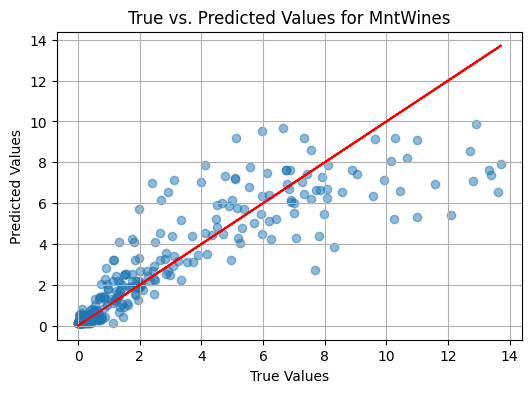

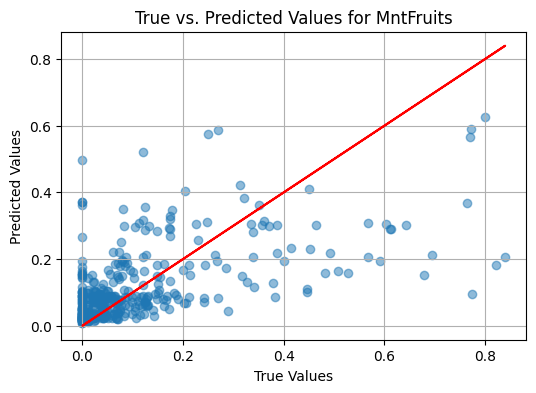

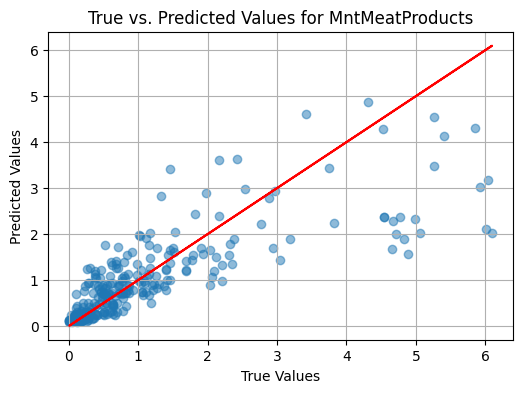

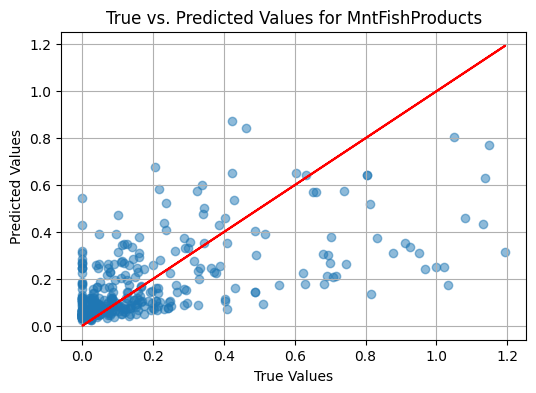

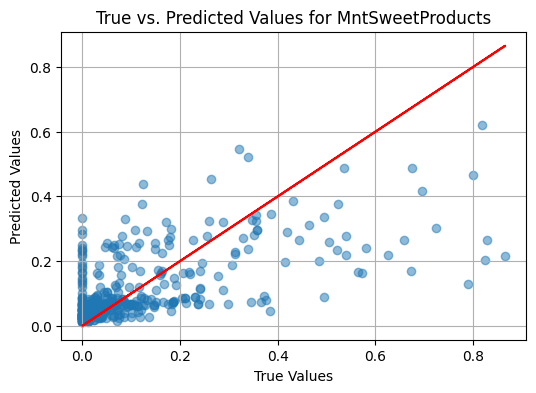

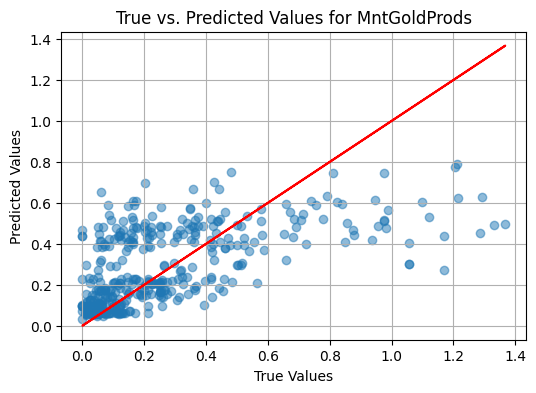

In [11]:
# Create scatter plots for each response variable
for col in test_y.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(test_y[col], result_df[col], alpha=0.5)  # Use test_y[col] for true values
    plt.plot(test_y[col], test_y[col], color='red')  # Plot the diagonal line (perfect predictions)
    plt.title(f"True vs. Predicted Values for {col}")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.grid(True)
    plt.show()

### Conclusion
The blue dots (scatter) reflect the model's predicted values while the red line reflect the perfect predictions. This shows us the distance between the predicted and actual values, while also giving us a rough visual gauge of how accurate the model is.

From the Goodness of Fit of the Model we can see that
| Gradient Boosting | Explained Variance (R^2) (Test) | Mean Squared Error (MSE) (Test) | Root Mean Squared Error (RMSE) (Test) |
|-------------|----------------------------------|----------------------------------|---------------------------------------|
| 11           | 0.485                          | 0.413                          | 0.642                                |

The explained variance of 0.485 shows that the Gradient Boosting Regression model is definitely not the best one we can use. However, it is still a great model that can predict with certain accuracy about the amount of products by type that a customer would purchase in the store, as supported by its lower Mean Squared Error.